In [1]:
import torch
from transformers import AutoFeatureExtractor, HubertModel


import numpy as np
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import os
import librosa.display


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from torchsummary import summary
from tqdm import tqdm

/home/workspace/anaconda3/envs/home/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sf = 16000
batch_size = 4

# Load One Data

In [3]:
one_data = '/mnt/c/Users/user/Desktop/Roshidat/Workspace/PD_prediction/data/1_data/HC_AH/AH_114S_A89F3548-0B61-4770-B800-2E26AB3908B6.wav'
data_one, _ = librosa.load(one_data, sr=sf)

data_one.shape

(36278,)

In [4]:
model_name="facebook/hubert-base-ls960"
device = "cuda" if torch.cuda.is_available() else "cpu"
feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)
model = HubertModel.from_pretrained(model_name).to(device).eval()

In [5]:
model

HubertModel(
  (feature_extractor): HubertFeatureEncoder(
    (conv_layers): ModuleList(
      (0): HubertGroupNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (activation): GELUActivation()
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
      )
      (1-4): 4 x HubertNoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (5-6): 2 x HubertNoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
    )
  )
  (feature_projection): HubertFeatureProjection(
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=512, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): HubertEncoder(
    (pos_conv_embed): HubertPositionalConvEmbedding(
      (conv): Para

In [6]:
# inputs = feature_extractor(
#     torch.tensor(data_one),
#     sampling_rate=16000,
#     return_tensors="pt",
#     padding=True
# )
# input_values = inputs["input_values"].to(device)

In [7]:
# outputs = model(input_values, output_hidden_states=True)

In [8]:
# last_k_layers = -1
# hs = outputs.hidden_states
# selected = hs[-last_k_layers:]
# stacked = torch.stack(selected, dim=0)      # (K, B, T', D)
# frame_embeddings = stacked.mean(dim=0)      # (B, T', D)
# frame_embeddings.shape
# utterance_embeddings = frame_embeddings.mean(dim=1) 
# utterance_embeddings.shape
# utterance_embeddings = torch.nn.functional.normalize(utterance_embeddings, dim=1)

# utterance_embeddings.reshape(24, 32).shape


In [9]:
def extract_hubert_feature(data, feature_extractor, model, desired_layer, sf, device):

    data = torch.tensor(data).to(device)
    inputs = feature_extractor(data, return_tensors="pt", sampling_rate=sf, padding=True).to(device)
    input_values = inputs["input_values"].to(device)
    outputs = model(input_values, output_hidden_states=True)

    hs = outputs.hidden_states # (layers, batch, time, features)
    selected = hs[desired_layer:]
    stacked = torch.stack(selected, dim=0)      # (K, B, T', D)
    frame_embeddings = stacked.mean(dim=0) 

    utterance_embeddings = frame_embeddings.mean(dim=1) 
    
    utterance_embeddings = torch.nn.functional.normalize(utterance_embeddings, dim=1)
    utterance_embeddings = utterance_embeddings.squeeze()
    utterance_embeddings = utterance_embeddings.detach().cpu().numpy()

    return utterance_embeddings


In [10]:
desired_layer = 1

sample_data = extract_hubert_feature(data_one, feature_extractor, model, desired_layer, sf, device)

In [11]:
sample_data.shape

(768,)

In [12]:

# @torch.no_grad()
# def hubert_embed_batch(
#     wav_list,
#     model_name="facebook/hubert-base-ls960",
#     last_k_layers=1,
#     normalize=False,
#     device=None
# ):
#     device = device or ("cuda" if torch.cuda.is_available() else "cpu")
#     feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)
#     model = HubertModel.from_pretrained(model_name).to(device).eval()

#     # Prepare features with automatic padding
#     inputs = feature_extractor(
#         wav_list,
#         sampling_rate=TARGET_SR,
#         return_tensors="pt",
#         padding=True
#     )
#     input_values = inputs["input_values"].to(device)

#     outputs = model(input_values, output_hidden_states=True)
#     hs = outputs.hidden_states
#     selected = hs[-last_k_layers:]
#     stacked = torch.stack(selected, dim=0)      # (K, B, T', D)
#     frame_embeddings = stacked.mean(dim=0)      # (B, T', D)

#     # Mean-pool over time to get utterance-level embeddings
#     utterance_embeddings = frame_embeddings.mean(dim=1)  # (B, D)

#     if normalize:
#         utterance_embeddings = torch.nn.functional.normalize(utterance_embeddings, dim=1)

#     return frame_embeddings.cpu(), utterance_embeddings.cpu()

# if __name__ == "__main__":
#     folder = Path("path/to/wav_folder")
#     wav_paths = sorted(folder.glob("*.wav"))

#     # Load all wavs into memory (careful if folder is huge)
#     wav_list = [load_wav_mono_16k(p) for p in wav_paths]

#     # Run HuBERT in batches (to avoid OOM, here we use batch_size=8)
#     all_frame_embeds = []
#     all_utt_embeds = []
#     batch_size = 8

#     for i in range(0, len(wav_list), batch_size):
#         batch_wavs = wav_list[i:i+batch_size]
#         frame_embeds, utt_embeds = hubert_embed_batch(
#             batch_wavs,
#             last_k_layers=1,
#             normalize=True
#         )
#         all_frame_embeds.extend(frame_embeds)
#         all_utt_embeds.extend(utt_embeds)

#     print(f"Processed {len(all_utt_embeds)} files")
#     print("Example utterance embedding shape:", all_utt_embeds[0].shape)  # (D,)
#     print("Example frame embedding shape:", all_frame_embeds[0].shape)    # (T', D)


# HC data

In [13]:
path = '/mnt/c/Users/user/Desktop/Roshidat/Workspace/PD_prediction/data/1_data/HC_AH'
dirc = os.listdir(path)
hc_data = []
for file in dirc:
    file_path = os.path.join(path, file)
    loaded_file, _ = librosa.load(file_path, sr=8000)

    extracted_data = extract_hubert_feature(loaded_file, feature_extractor, model, desired_layer, sf, device)
    hc_data.append(extracted_data)


In [14]:
# hc_data = np.array(hc_data)
# hc_data.shape

In [15]:
len(hc_data)

41

In [16]:
y_hc = np.zeros(len(hc_data))  # Create an array of zeros with the same length as hc_data_padded
y_hc

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])

# Load PD Data

In [17]:
pd_path = '/mnt/c/Users/user/Desktop/Roshidat/Workspace/PD_prediction/data/1_data/PD_AH'
pd_dirc = os.listdir(pd_path)

pd_data = []
for file in pd_dirc:
    file_path = os.path.join(pd_path, file)
    loaded_file, _ = librosa.load(file_path, sr=8000)
    
    extracted_data = extract_hubert_feature(loaded_file, feature_extractor, model, desired_layer, sf, device)
    pd_data.append(extracted_data)

In [18]:
len(pd_data)

40

In [19]:
y_pd = np.zeros(len(pd_data))+1  # Create an array of zeros with the same length as hc_data_padded
y_pd

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1.])

# All data

In [32]:
X = hc_data+pd_data
X = np.array(X)
y = np.concatenate((y_hc, y_pd))

X.shape, y.shape

((81, 768), (81,))

In [33]:
np.save('/mnt/c/Users/user/Desktop/Roshidat/Workspace/PD_prediction/data/1_data/hubert_feature_extracted/X_hubert_2_layer.npy', X)
np.save('/mnt/c/Users/user/Desktop/Roshidat/Workspace/PD_prediction/data/1_data/hubert_feature_extracted/y_hubert_2_layer.npy', y)

In [21]:
y

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

Text(0.5, 1.0, 'Count per Label in y_train')

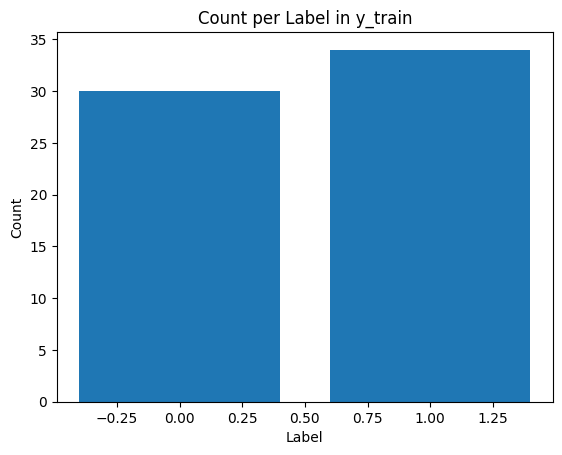

In [23]:


# Plot the count per label in y_train
unique, counts = np.unique(y_train, return_counts=True)
plt.bar(unique, counts)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Count per Label in y_train')

# SVM

In [24]:
from sklearn import svm
from sklearn.metrics import accuracy_score

import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from xgboost import XGBClassifier

In [25]:

svm_model = svm.SVC()
svm_model.fit(X_train, y_train)

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [26]:
y_pred = svm_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f'The accuracy is {acc*100:.2f}%')

The accuracy is 82.35%


# XGBOOST

In [30]:
# Compute scale_pos_weight = #neg / #pos (robust to imbalance)
n_pos = (y == 1).sum()
n_neg = (y == 0).sum()
scale_pos_weight = (n_neg / max(n_pos, 1)) if n_pos > 0 else 1.0

In [28]:
X_val, y_val = X_test, y_test

In [31]:
clf = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    n_estimators=2000,        # large cap + early stopping
    learning_rate=0.03,
    max_depth=3,
    min_child_weight=2,
    subsample=0.8,
    colsample_bytree=0.6,
    reg_lambda=2.0,
    reg_alpha=0.0,
    scale_pos_weight=scale_pos_weight,
    tree_method="hist",       # use "gpu_hist" if you have a GPU
    random_state=42
)

# Train with early stopping
clf.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False,
)

# Evaluate (threshold = 0.5 by default)
proba_val = clf.predict_proba(X_val)[:, 1]
pred_val = (proba_val >= 0.5).astype(int)

acc = accuracy_score(y_val, pred_val)
f1  = f1_score(y_val, pred_val)
auc = roc_auc_score(y_val, proba_val)

print(f"Best iteration: {clf.get_booster()}")
print(f"Validation Accuracy: {acc:.4f}")
print(f"Validation F1:       {f1:.4f}")
print(f"Validation ROC-AUC:  {auc:.4f}")
print("\nClassification report:\n", classification_report(y_val, pred_val, digits=4))

# Optional: quick 5-fold CV accuracy (uses best params found above)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(clf, X, y, cv=cv, scoring="accuracy")
print(f"\n5-fold CV accuracy: mean={cv_scores.mean():.4f}, std={cv_scores.std():.4f}")

Best iteration: <xgboost.core.Booster object at 0x7bb15e34ffe0>
Validation Accuracy: 0.5882
Validation F1:       0.5882
Validation ROC-AUC:  0.6818

Classification report:
               precision    recall  f1-score   support

         0.0     0.8333    0.4545    0.5882        11
         1.0     0.4545    0.8333    0.5882         6

    accuracy                         0.5882        17
   macro avg     0.6439    0.6439    0.5882        17
weighted avg     0.6996    0.5882    0.5882        17


5-fold CV accuracy: mean=0.6662, std=0.0343
